In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features, plot_roc, boxplot_binary_predictions
from stabl.adaptive import ALasso, ALogitLasso
from stabl import data

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import clone
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer

%config InlineBackend.figure_formats=['retina'] 

/Users/aanya/Desktop/old research/vaccine challenge/.venv/lib/python3.13/site-packages/stabl/stabl.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Specimens and data files.
data_dir = "data/"
specimens_file = "subject_specimen.tsv"
pbmc_cell_freq_file = "pbmc_cell_frequency.tsv"
pbmc_cell_freq_normalized_file = "pbmc_cell_frequency_normalized.tsv"
pbmc_gene_expr_file = "pbmc_gene_expression_raw_count.tsv"
pbmc_gene_expr_raw_file = "pbmc_gene_expression_raw_count_raw_data.tsv"
plasma_ab_titer_file = "plasma_ab_titer.tsv"
plasma_ab_titer_normalized_file = "plasma_ab_titer_normalized.tsv"
plasma_cytokine_file = "plasma_cytokine_concentrations_by_olink.tsv"
t_cell_act_file = "t_cell_activation.tsv"
t_cell_pol_file = "t_cell_polarization.tsv"
th1_th2_pol_file = "Th1_Th2_polarization_ratio.tsv"
challenge_specimens_file = "challenge_subject_specimen.tsv"
tranining_specimens_file = "training_subject_specimen.tsv"

In [3]:
# Load batch corrected data into assay dictionary. Use batch corrected to avoid batch effects. 
assays = {}
assays["pbmc_cell_freq"] = pbmc_cell_freq_file
assays["pbmc_gene_expr"] = pbmc_gene_expr_file
assays["plasma_ab_titer"] = plasma_ab_titer_file
assays["plasma_cytokine"] = plasma_cytokine_file
assays["t_cell_act"] = t_cell_act_file
assays["t_cell_pol"] = t_cell_pol_file
assays["th1_th2_pol"] = th1_th2_pol_file

# Use pre batch corrected data for the FC calculations, since batch correction can change the fold change value.
assays["pbmc_cell_freq_normalized"] = pbmc_cell_freq_normalized_file
assays["pbmc_gene_expr_raw"] = pbmc_gene_expr_raw_file
assays["plasma_ab_titer_normalized"] = plasma_ab_titer_normalized_file

datasets = ["2020_dataset", "2021_dataset", "2022_dataset", "2023_dataset"]
training_datasets = ["2020_dataset", "2021_dataset", "2022_dataset"]

batch_corrected_assays = [
    "plasma_ab_titer",
    "plasma_cytokine",
    "pbmc_gene_expr",
    "pbmc_cell_freq",
    "t_cell_act",
    "t_cell_pol",
    "th1_th2_pol",
]

pre_batch_corrected_assays = ["pbmc_cell_freq_normalized", "pbmc_gene_expr_raw", "plasma_ab_titer_normalized"]

# All challenges.
challenges = [
    "1.1) IgG-PT-D14-titer-Rank",
    "1.2) IgG-PT-D14-FC-Rank",
    "2.1) Monocytes-D1-Rank",
    "2.2) Monocytes-D1-FC-Rank",
    "3.1) CCL3-D3-Rank",
    "3.2) CCL3-D3-FC-Rank",
    "4.1) IFNG/IL5-Polarization-D30-Rank",
]

# Features and assays for each challenge.
igg_feature_name = "IgG_PT"
igg_assay = "plasma_ab_titer"

monocytes_feature_name = "Monocytes"
monocytes_assay = "pbmc_cell_freq"

ccl3_feature_name = "ENSG00000277632.1"
ccl3_assay = "pbmc_gene_expr"

bonus_feature_name = "PT_P01579(IFNγ)/PT_P05113(IL5)"
bonus_assay = "th1_th2_pol"

# Random seed.
random_state = 42

In [4]:
# Get metadata about all the specimens.
specimens = pd.read_table(data_dir + specimens_file)
specimens = specimens.set_index("specimen_id")
challenge_specimens = pd.read_table(data_dir + challenge_specimens_file).set_index("specimen_id")
training_specimens = pd.read_table(data_dir + tranining_specimens_file).set_index("specimen_id")

# Get age of each specimen based on year of birth and date of boost.
def get_age(row):
    date_format = "%Y-%m-%d"
    birth = datetime.strptime(row["year_of_birth"], date_format)
    boost = datetime.strptime(row["date_of_boost"], date_format)
    return boost.year - birth.year

# Merge age with metadata about specimens.
challenge_specimens["age"] = challenge_specimens.apply(get_age, axis=1)
training_specimens["age"] = training_specimens.apply(get_age, axis=1)
all_specimens_age = pd.concat([challenge_specimens[["age"]], training_specimens[["age"]]])
specimens = specimens.merge(all_specimens_age, left_index=True, right_index=True, how="left")

In [5]:
# Load all assay data into a dictionary.
# Transpose the dataframes so that specimens are rows and features are columns.
assay_data = {}
for assay, file in assays.items():
    df = pd.read_table(data_dir + file)
    if assay != bonus_assay:
        # The bonus dataset does not require a transpose
        df = df.T
    else:
        df = df.set_index("specimen_id")
    df.index = df.index.astype("int64")
    df.index.name = "specimen_id"
    # Remove the dataset column if it exists, as it is not needed for analysis.
    if "dataset" in df.columns:
        df = df.drop("dataset", axis=1)
    assay_data[assay] = df

In [6]:
def print_assay_data_stats(timepoint):
    assay_data_stats = {}
    print(f"TIMEPOINT                 ", timepoint)
    for assay, data in assay_data.items():
        # Only consider batch corrected assays to see distribution of specimens across datasets and timepoints.
        if "_normalized" in assay or "_raw" in assay:
            continue
        merged_assay_data = data.merge(specimens, left_index=True, right_index=True, how="left")
        merged_assay_data = merged_assay_data[merged_assay_data["timepoint"] == timepoint].drop("timepoint", axis=1)
        counts = []
        for dataset in datasets:
            count = len(merged_assay_data[merged_assay_data["dataset"] == dataset])
            counts.append(count)
        assay_data_stats[assay] = counts

    for key, value in assay_data_stats.items():
        print(f"{key:<30}", value)

    subjects = []
    # Count number of subjects for each dataset at given timepoint (ignoring assay).
    for dataset in datasets:
        baseline_specimens = specimens[specimens["timepoint"] == timepoint]
        count = len(baseline_specimens[baseline_specimens["dataset"] == dataset])
        subjects.append(count)
    print(f"Subject count                 ", subjects)


print_assay_data_stats(0)
# print_assay_data_stats(-14)
# print_assay_data_stats(-15)
# print_assay_data_stats(-30)

TIMEPOINT                  0
pbmc_cell_freq                 [20, 33, 21, 48]
pbmc_gene_expr                 [36, 36, 21, 53]
plasma_ab_titer                [58, 33, 21, 54]
plasma_cytokine                [18, 36, 19, 32]
t_cell_act                     [0, 34, 20, 52]
t_cell_pol                     [0, 27, 16, 51]
th1_th2_pol                    [0, 27, 16, 51]
Subject count                  [60, 36, 21, 54]


In [7]:
def get_input_data(individual_assay_data, relevant_assays, relevant_datasets, timepoint):
    # Concatenate all relevant assays into a single input dataframe.
    input_data = pd.concat(
        (lambda d, k: [d[key] for key in k])(individual_assay_data, relevant_assays),
        axis=1,
    )
    input_data = input_data.merge(specimens, left_index=True, right_index=True, how="left")
    # Take only relevant datasets.
    input_data = input_data[input_data["dataset"].isin(relevant_datasets)]
    input_data = input_data.drop("date_of_boost", axis=1)

    # Convert infancy_vac and biological_sex to numerical features.
    label_encoder = LabelEncoder()
    input_data["infancy_vac"] = label_encoder.fit_transform(input_data["infancy_vac"])
    input_data["biological_sex"] = label_encoder.fit_transform(input_data["biological_sex"])

    # Take only the relevant timepoints.
    input_data = input_data[input_data["timepoint"] == timepoint].drop("timepoint", axis=1)
    input_data = input_data.set_index("subject_id")
    return input_data

In [8]:
def get_outcomes_dict(individual_assay_data, relevant_datasets):
    # Concat all batch corrected assays into a single input dataframe.
    input_data = pd.concat(
        (lambda d, k: [d[key] for key in k])(individual_assay_data, batch_corrected_assays),
        axis=1,
    )
    input_data = input_data.merge(specimens, left_index=True, right_index=True, how="left")
    input_data = input_data[input_data["dataset"].isin(relevant_datasets)].drop("dataset", axis=1)

    # Concat all pre batch corrected assays into a single dataframe.
    pre_batch_corrected_data = pd.concat(
        (lambda d, k: [d[key] for key in k])(individual_assay_data, pre_batch_corrected_assays),
        axis=1,
    )
    pre_batch_corrected_data = pre_batch_corrected_data.merge(specimens, left_index=True, right_index=True, how="left")
    pre_batch_corrected_data = pre_batch_corrected_data[
        pre_batch_corrected_data["dataset"].isin(relevant_datasets)
    ].drop("dataset", axis=1)

    # Create batch-corrected data for dataframes for each timepoint.
    timepoint_0 = input_data[input_data["timepoint"] == 0].set_index("subject_id")
    timepoint_1 = input_data[input_data["timepoint"] == 1].set_index("subject_id")
    timepoint_3 = input_data[input_data["timepoint"] == 3].set_index("subject_id")
    timepoint_14 = input_data[input_data["timepoint"] == 14].set_index("subject_id")
    timepoint_30 = input_data[input_data["timepoint"] == 30].set_index("subject_id")

    # Create pre-batch corrected data for each timepoint. 
    timepoint_0_pre_batch_corrected = pre_batch_corrected_data[pre_batch_corrected_data["timepoint"] == 0].set_index(
        "subject_id"
    )
    timepoint_1_pre_batch_corrected = pre_batch_corrected_data[pre_batch_corrected_data["timepoint"] == 1].set_index(
        "subject_id"
    )
    timepoint_3_pre_batch_corrected = pre_batch_corrected_data[pre_batch_corrected_data["timepoint"] == 3].set_index(
        "subject_id"
    )
    timepoint_14_pre_batch_corrected = pre_batch_corrected_data[pre_batch_corrected_data["timepoint"] == 14].set_index(
        "subject_id"
    )

    # Select features for each timepoint and add suffixes to distinguish between timepoints and batch corrected vs pre-batch corrected.
    timepoint_0_selected = timepoint_0[[igg_feature_name, monocytes_feature_name, ccl3_feature_name]].add_suffix("_0")
    timepoint_0_pre_batch_corrected_selected = timepoint_0_pre_batch_corrected[
        [igg_feature_name, monocytes_feature_name, ccl3_feature_name]
    ].add_suffix("_0P")
    timepoint_1_selected = timepoint_1[[monocytes_feature_name]]
    timepoint_1_pre_batch_corrected_selected = timepoint_1_pre_batch_corrected[[monocytes_feature_name]].add_suffix(
        "_P"
    )
    timepoint_3_selected = timepoint_3[[ccl3_feature_name]]
    timepoint_3_pre_batch_corrected_selected = timepoint_3_pre_batch_corrected[[ccl3_feature_name]].add_suffix("_P")
    timepoint_14_selected = timepoint_14[[igg_feature_name]]
    timepoint_14_pre_batch_corrected_selected = timepoint_14_pre_batch_corrected[[igg_feature_name]].add_suffix("_P")
    timepoint_30_selected = timepoint_30[[bonus_feature_name]]

    # Concat all selected feature data into a single dataframe.
    all_selected = pd.concat(
        [
            timepoint_0_selected,
            timepoint_0_pre_batch_corrected_selected,
            timepoint_1_selected,
            timepoint_1_pre_batch_corrected_selected,
            timepoint_3_selected,
            timepoint_3_pre_batch_corrected_selected,
            timepoint_14_selected,
            timepoint_14_pre_batch_corrected_selected,
            timepoint_30_selected,
        ],
        axis=1,
    )

    # Save outcome data using selected feature from each challenge. For FC challenges, calculate fold change using pre-batch corrected data.
    outcomes_dict = {}
    outcomes_dict[challenges[0]] = all_selected[igg_feature_name]
    outcomes_dict[challenges[1]] = all_selected[igg_feature_name + "_P"] / all_selected[igg_feature_name + "_0P"]
    outcomes_dict[challenges[1]].name = igg_feature_name + "_FC"

    outcomes_dict[challenges[2]] = all_selected[monocytes_feature_name]
    outcomes_dict[challenges[3]] = (
        all_selected[monocytes_feature_name + "_P"] / all_selected[monocytes_feature_name + "_0P"]
    )
    outcomes_dict[challenges[3]].name = monocytes_feature_name + "_FC"

    outcomes_dict[challenges[4]] = all_selected[ccl3_feature_name]
    outcomes_dict[challenges[5]] = all_selected[ccl3_feature_name + "_P"] / all_selected[ccl3_feature_name + "_0P"]
    outcomes_dict[challenges[5]].name = ccl3_feature_name + "_FC"

    outcomes_dict[challenges[6]] = all_selected[bonus_feature_name]

    return outcomes_dict

In [9]:
# Drops filters with percentage of missing values above a threshold.
def low_info_filter(df, threshold):
    missing_percentages = df.isnull().mean()
    return df.loc[:, missing_percentages <= threshold]

# Impute missing values using KNN imputer.
def impute_missing_values(df):
    # Initialize the KNN Imputer with k=3
    knn_imputer = KNNImputer(n_neighbors=3)

    # Fit and transform the data
    return pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

# Normalizes values in dataframe.
def scale_values(df):
    std_scaler = StandardScaler()
    return pd.DataFrame(std_scaler.fit_transform(df), columns=df.columns, index=df.index)

# Normalizes values in series.
def scale_series(s):
    std_scaler = StandardScaler()
    data_normalized = std_scaler.fit_transform(s.values.reshape(-1, 1))
    return pd.Series(data_normalized.flatten(), index=s.index)

In [10]:
experiment = "experiment2"

# datasets_to_use = ["2022_dataset"]
# datasets_to_use = ["2021_dataset", "2022_dataset"]
datasets_to_use = ["2020_dataset", "2021_dataset", "2022_dataset"]

# prune_assay = False
prune_assay = True

input_data = get_input_data(assay_data, batch_corrected_assays, datasets_to_use, timepoint=0)
print("Input subjects: ", len(input_data))
print("Input features: ", len(input_data.columns))
assert len(input_data.columns.unique()) == len(input_data.columns)

outcomes_dict = get_outcomes_dict(assay_data, datasets_to_use)

# For each challenge, remove specimens that do not have outcome. 
def prune_data_without_outcomes(input_data, outcome_data):
    assert len(input_data) == len(outcome_data)
    pruned_outcome_data = outcome_data[~outcome_data.isna()]
    pruned_input_data = input_data[input_data.index.isin(pruned_outcome_data.index)]
    assert len(pruned_input_data) == len(pruned_outcome_data)
    return pruned_input_data, pruned_outcome_data

# Remove specimens that do not have assay data if assay required for that challenge.
def prune_data_without_assay(input_data, outcome_data, feature, dataset):
    assert len(input_data) == len(outcome_data)
    pruned_input_data = input_data[~(input_data[feature].isna() & (input_data["dataset"] == dataset))]
    pruned_outcome_data = outcome_data[outcome_data.index.isin(pruned_input_data.index)]
    assert len(pruned_input_data) == len(pruned_outcome_data)
    return pruned_input_data, pruned_outcome_data

# Create training data dictionary with training data for each challenge.
training_data_dict = {}
for challenge, outcome_data in outcomes_dict.copy().items():
    pruned_input_data, pruned_outcome_data = prune_data_without_outcomes(input_data, outcome_data)

    # Further prune based on missing assay on a specific dataset.
    if prune_assay:
        pruned_input_data, pruned_outcome_data = prune_data_without_assay(
            pruned_input_data, pruned_outcome_data, monocytes_feature_name, "2020_dataset"
        )

    training_data_dict[challenge] = pruned_input_data.drop("dataset", axis=1)
    outcomes_dict[challenge] = pruned_outcome_data

for challenge, data in outcomes_dict.items():
    print(
        challenge,
        "Samples :",
        len(data),
        "Missing outcomes:",
        data.isna().sum(),
        "Negative outcomes: ",
        (data < 0).sum().sum(),
    )

Input subjects:  115
Input features:  6779
1.1) IgG-PT-D14-titer-Rank Samples : 74 Missing outcomes: 0 Negative outcomes:  1
1.2) IgG-PT-D14-FC-Rank Samples : 74 Missing outcomes: 0 Negative outcomes:  0
2.1) Monocytes-D1-Rank Samples : 74 Missing outcomes: 0 Negative outcomes:  0
2.2) Monocytes-D1-FC-Rank Samples : 74 Missing outcomes: 0 Negative outcomes:  0
3.1) CCL3-D3-Rank Samples : 73 Missing outcomes: 0 Negative outcomes:  0
3.2) CCL3-D3-FC-Rank Samples : 73 Missing outcomes: 0 Negative outcomes:  0
4.1) IFNG/IL5-Polarization-D30-Rank Samples : 46 Missing outcomes: 0 Negative outcomes:  0


In [11]:
# Drop features with many missing values, impute missing values and scale.
def preprocess_training_data(training_data, outcome="", filter_threshold=0.2):
    training_data_filtered = low_info_filter(training_data, filter_threshold)
    print("Dropped", len(training_data.columns) - len(training_data_filtered.columns), "features for", outcome)
    # for key in training_data.columns:
    #    if key not in training_data_filtered.columns:
    #        print("Dropped feature ", key)
    training_data_imputed = impute_missing_values(training_data_filtered)
    training_data_scaled = scale_values(training_data_imputed)
    return training_data_scaled


for key, value in training_data_dict.copy().items():
    training_data_dict[key] = preprocess_training_data(value, key)
    
    # Scale outcomes
    # outcomes_dict[key] = scale_series(outcomes_dict[key])

Dropped 10 features for 1.1) IgG-PT-D14-titer-Rank
Dropped 10 features for 1.2) IgG-PT-D14-FC-Rank
Dropped 10 features for 2.1) Monocytes-D1-Rank
Dropped 10 features for 2.2) Monocytes-D1-FC-Rank
Dropped 10 features for 3.1) CCL3-D3-Rank
Dropped 10 features for 3.2) CCL3-D3-FC-Rank
Dropped 0 features for 4.1) IFNG/IL5-Polarization-D30-Rank


In [ ]:
# Create base lasso model for STABL feature selection.
lasso = Lasso(max_iter=int(1e7), random_state=random_state)

# Run STABL feature selection for each challenge.
stabl_regression_dict = {}
for challenge in challenges:
    stabl_regression_dict[challenge] = Stabl(
        base_estimator=clone(lasso),
        lambda_grid="auto",
        n_lambda=20,
        artificial_type="knockoff",
        n_bootstraps=1000,
        random_state=random_state,
        verbose=1,
    )

for challenge in challenges:
    stabl_regression_dict[challenge].fit(training_data_dict[challenge], outcomes_dict[challenge])

Stabl progress: 100%|██████████| 20/20 [08:56<00:00, 26.82s/it]


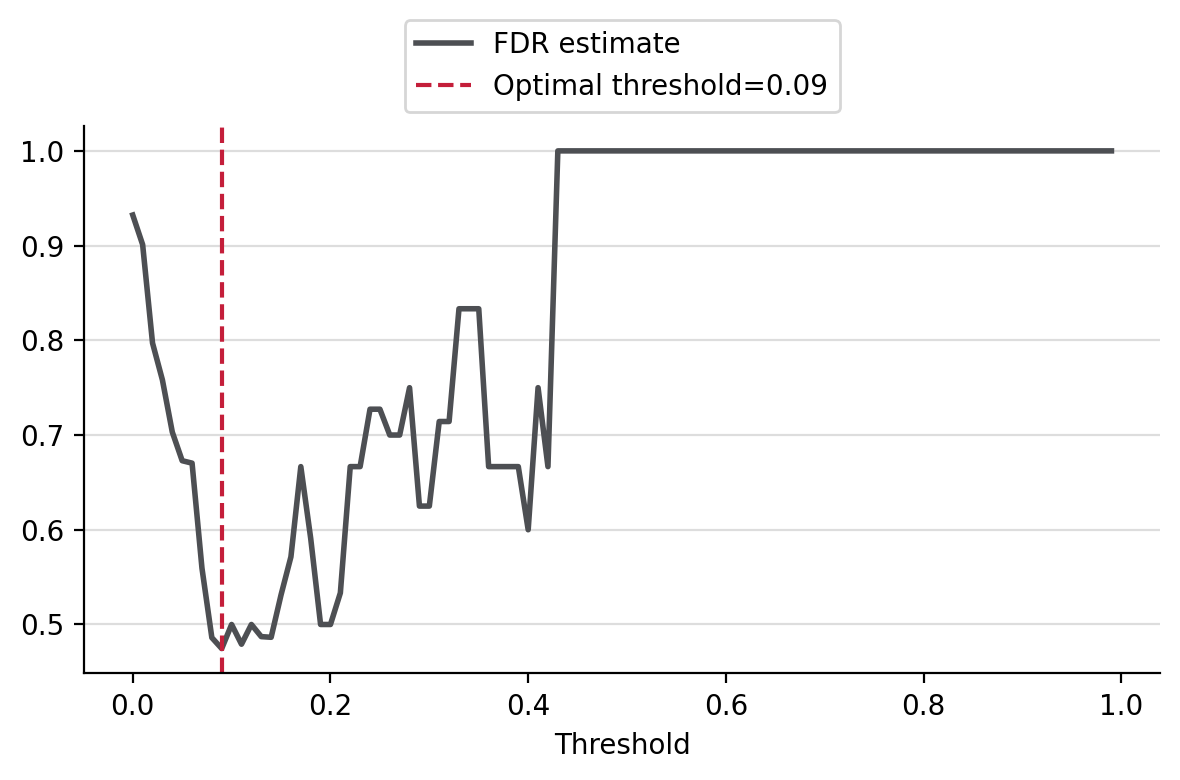

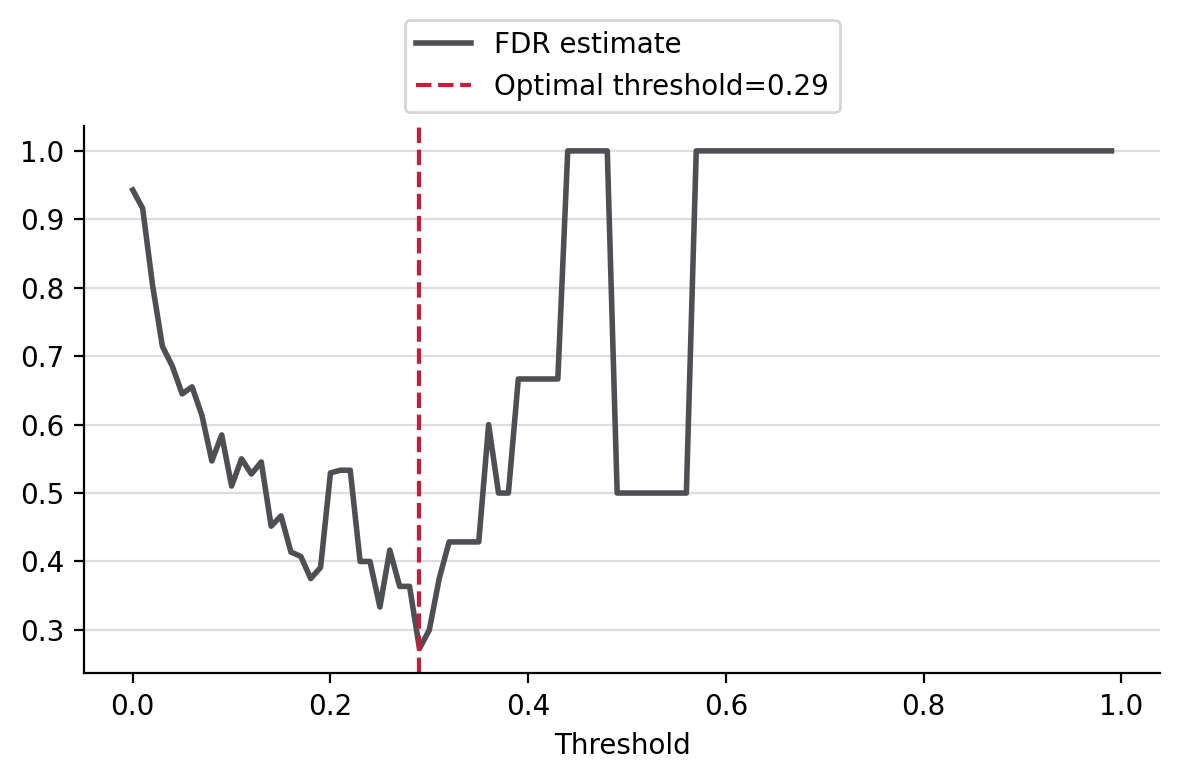

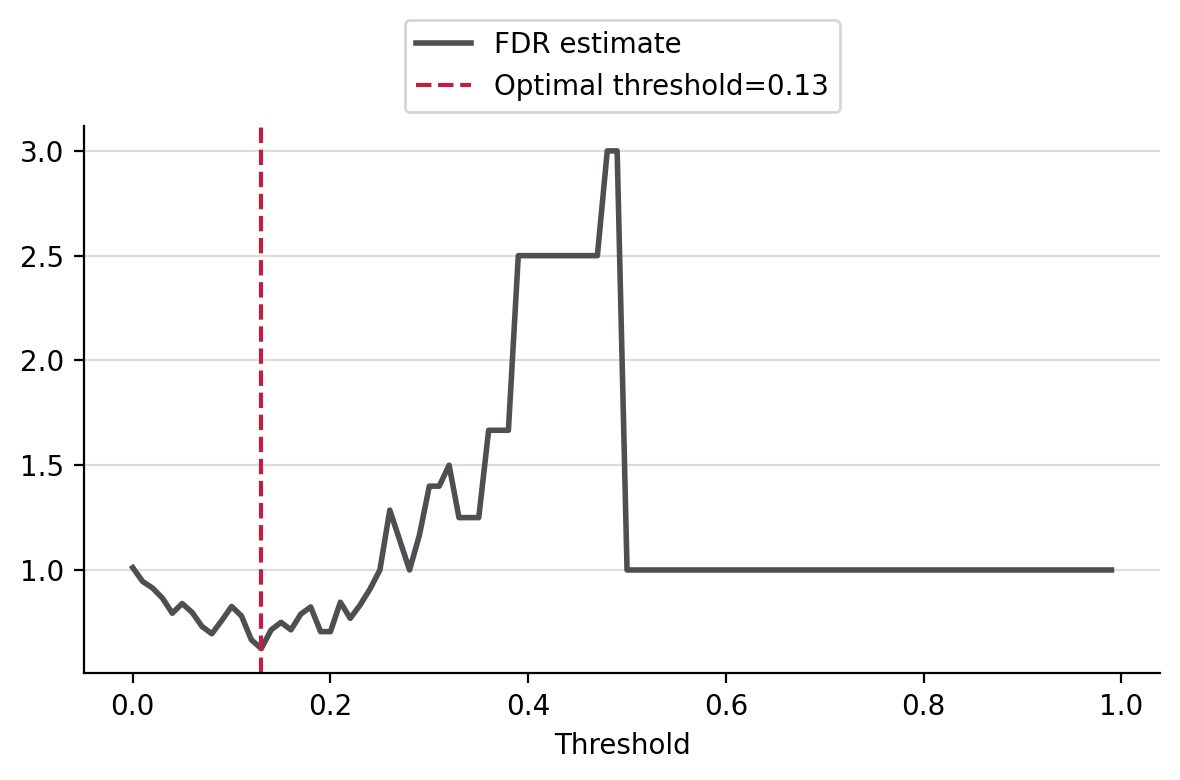

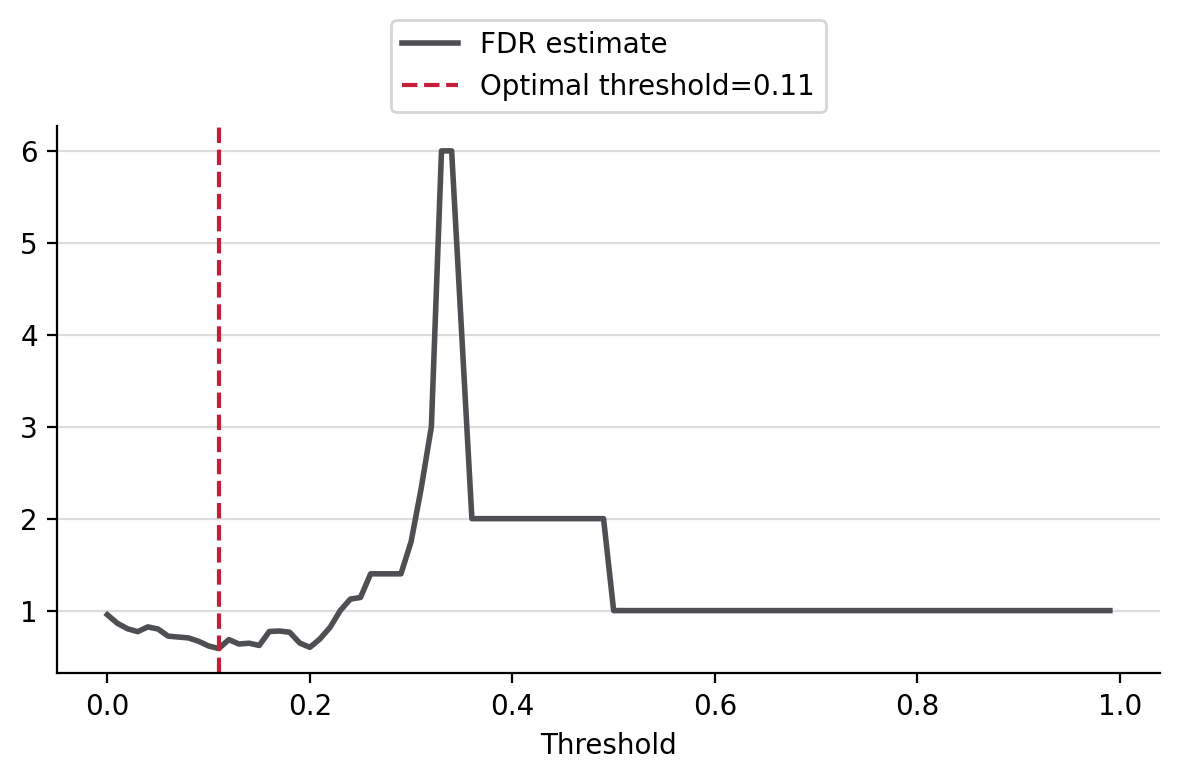

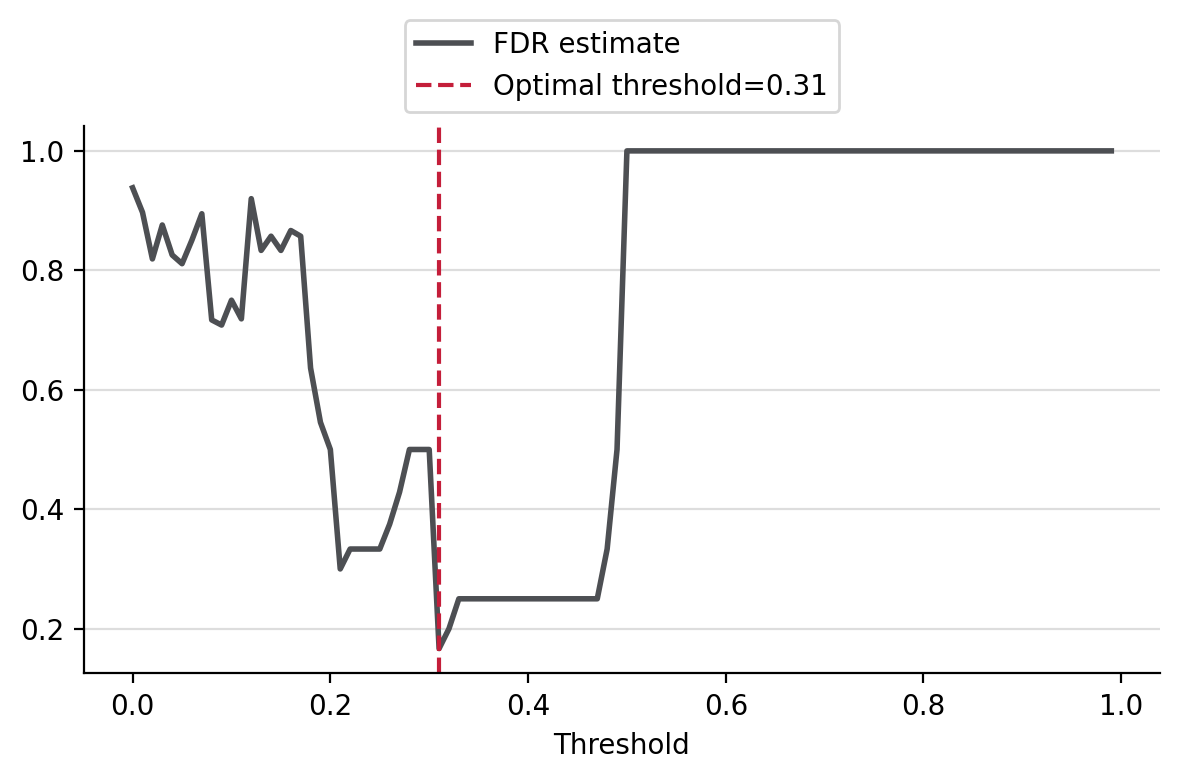

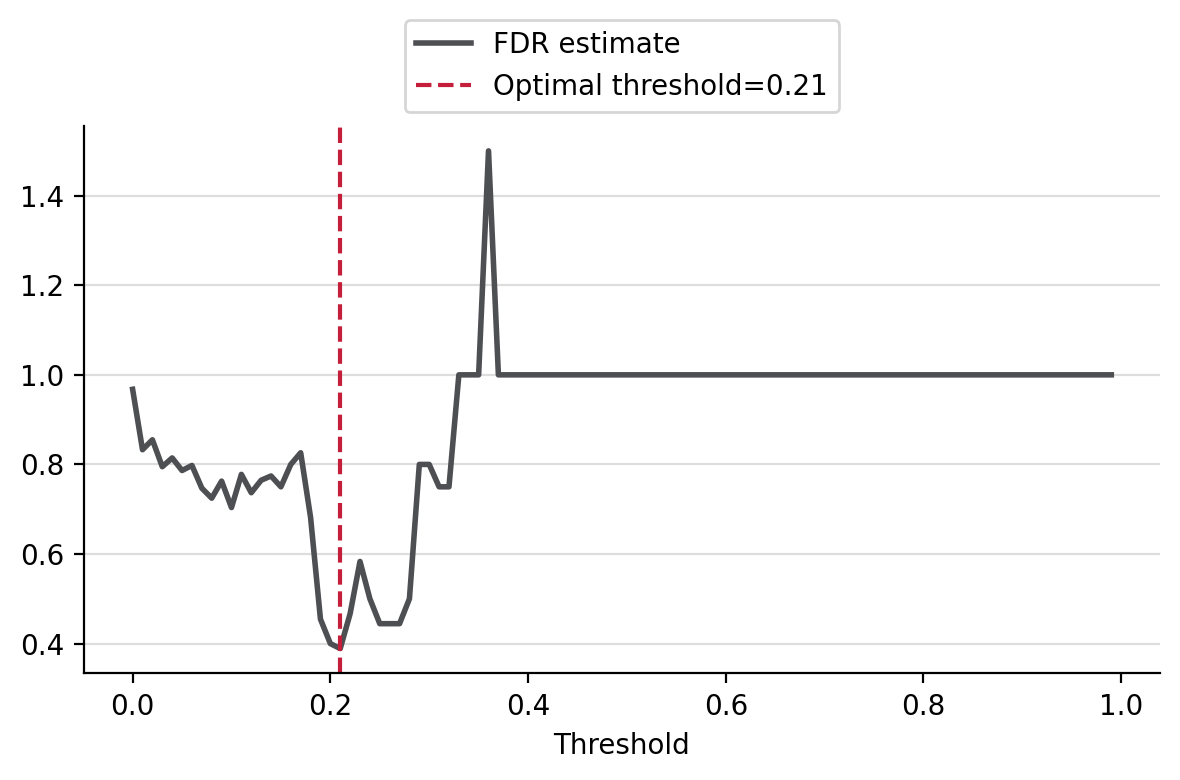

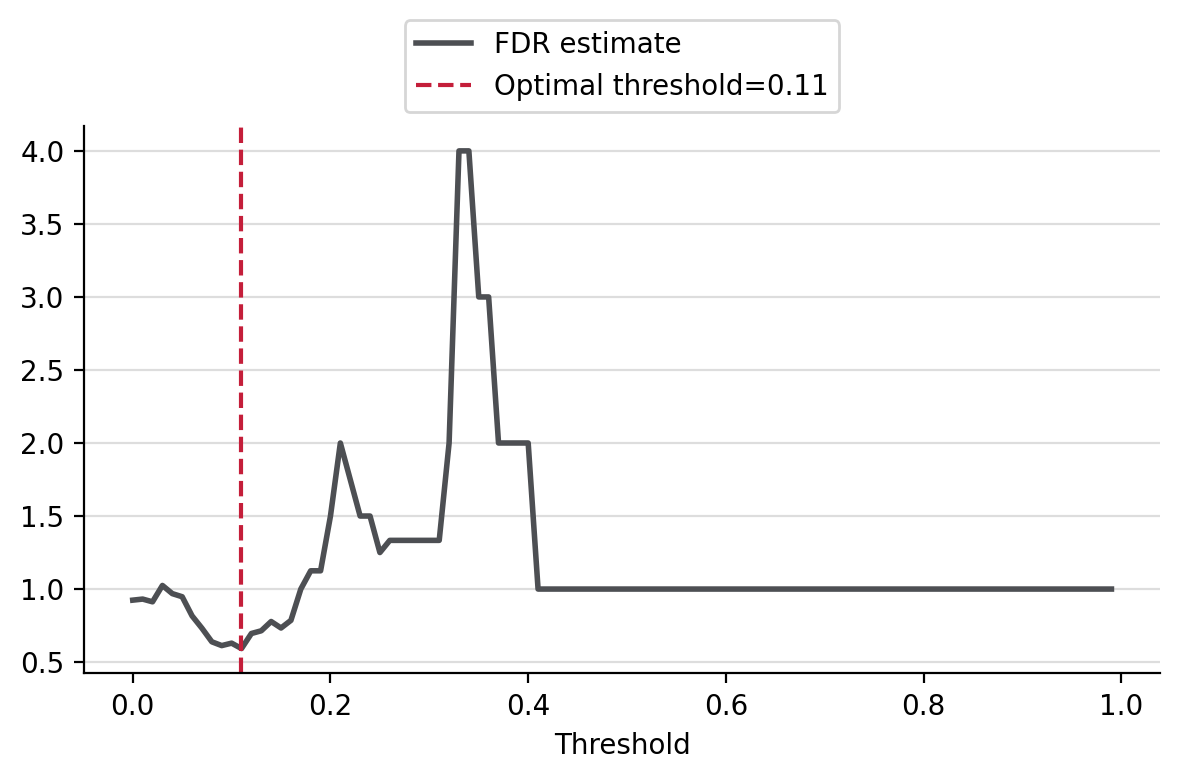

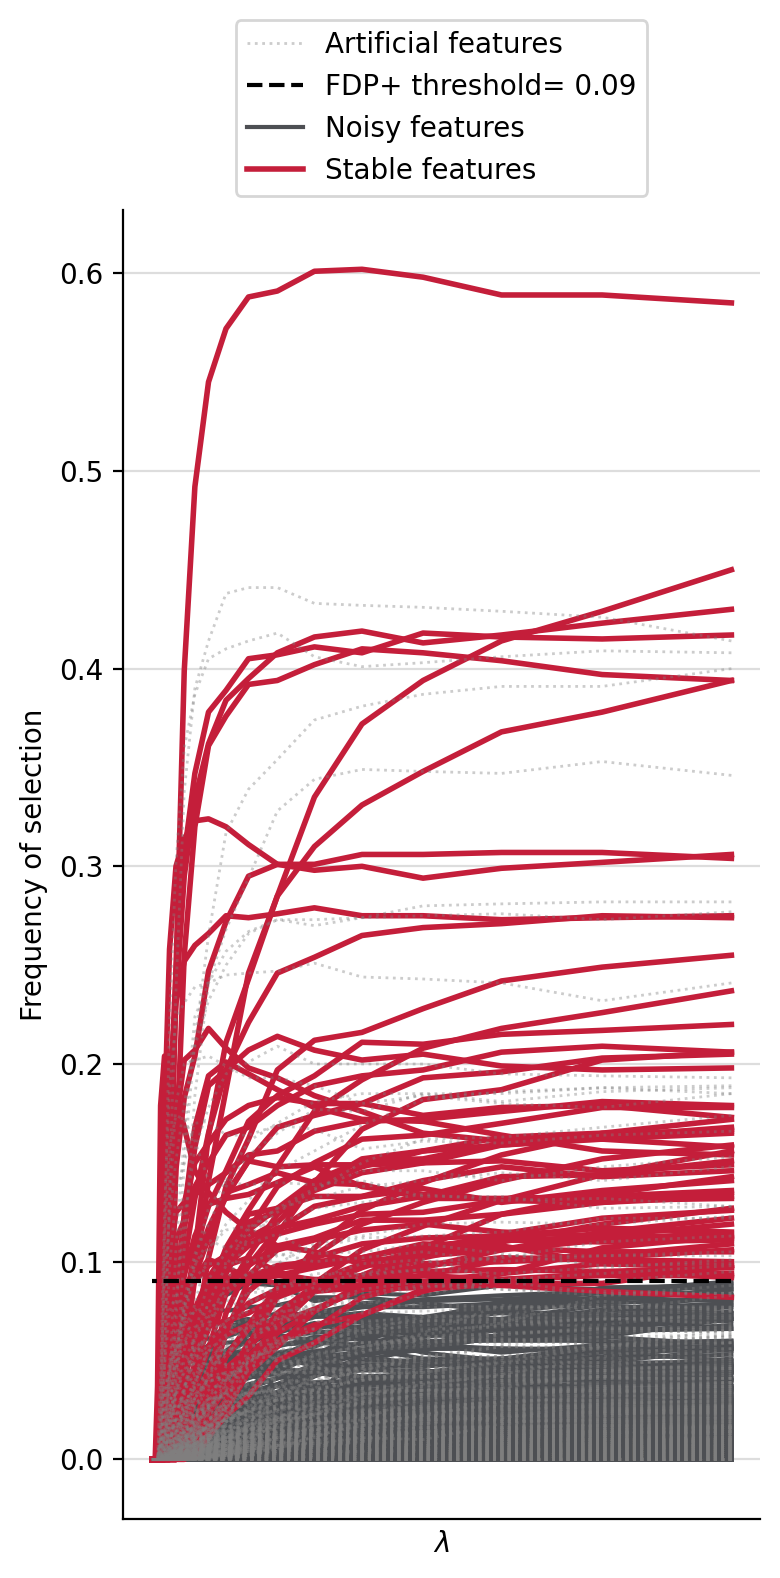

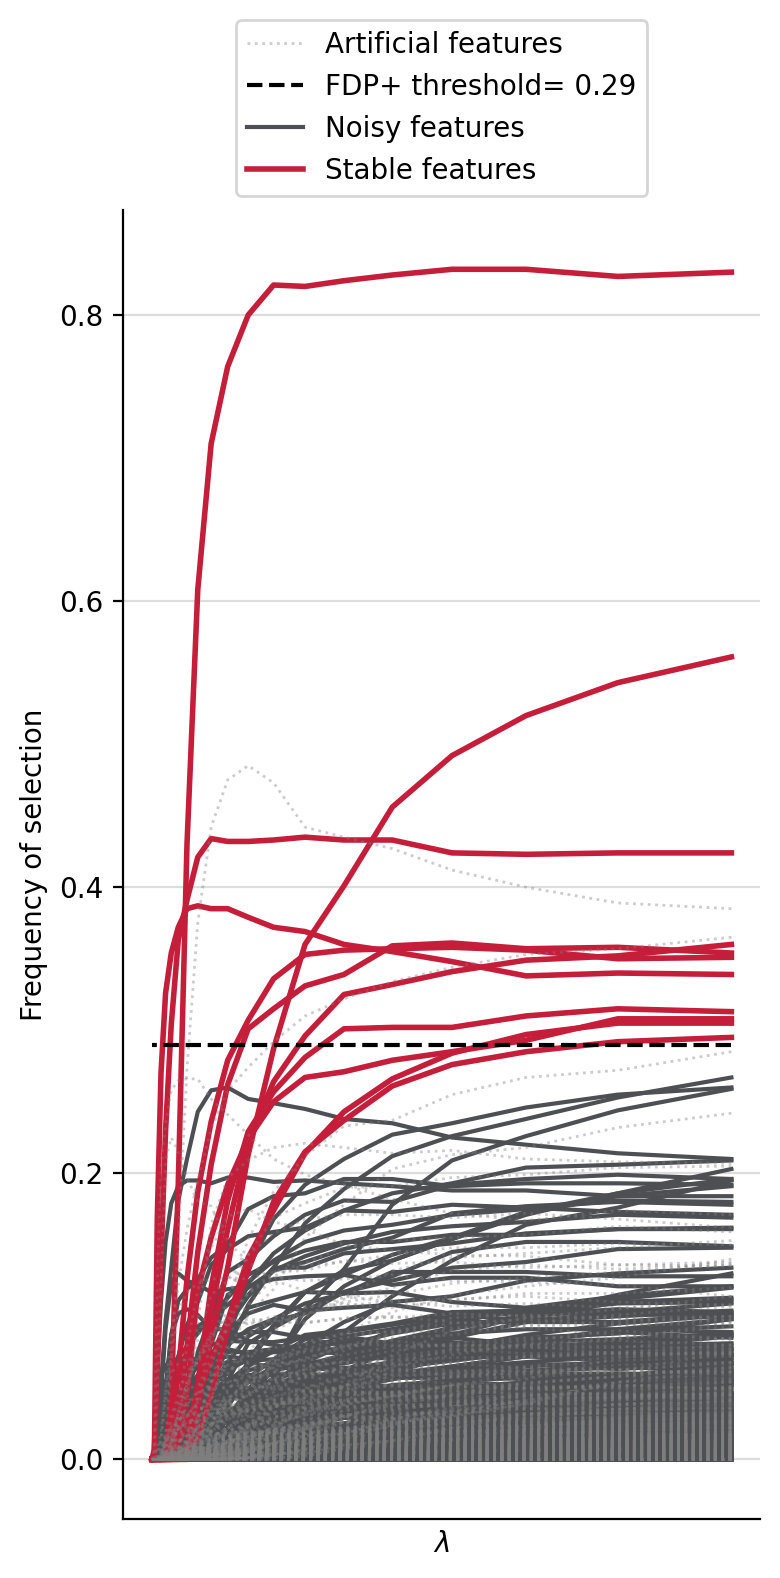

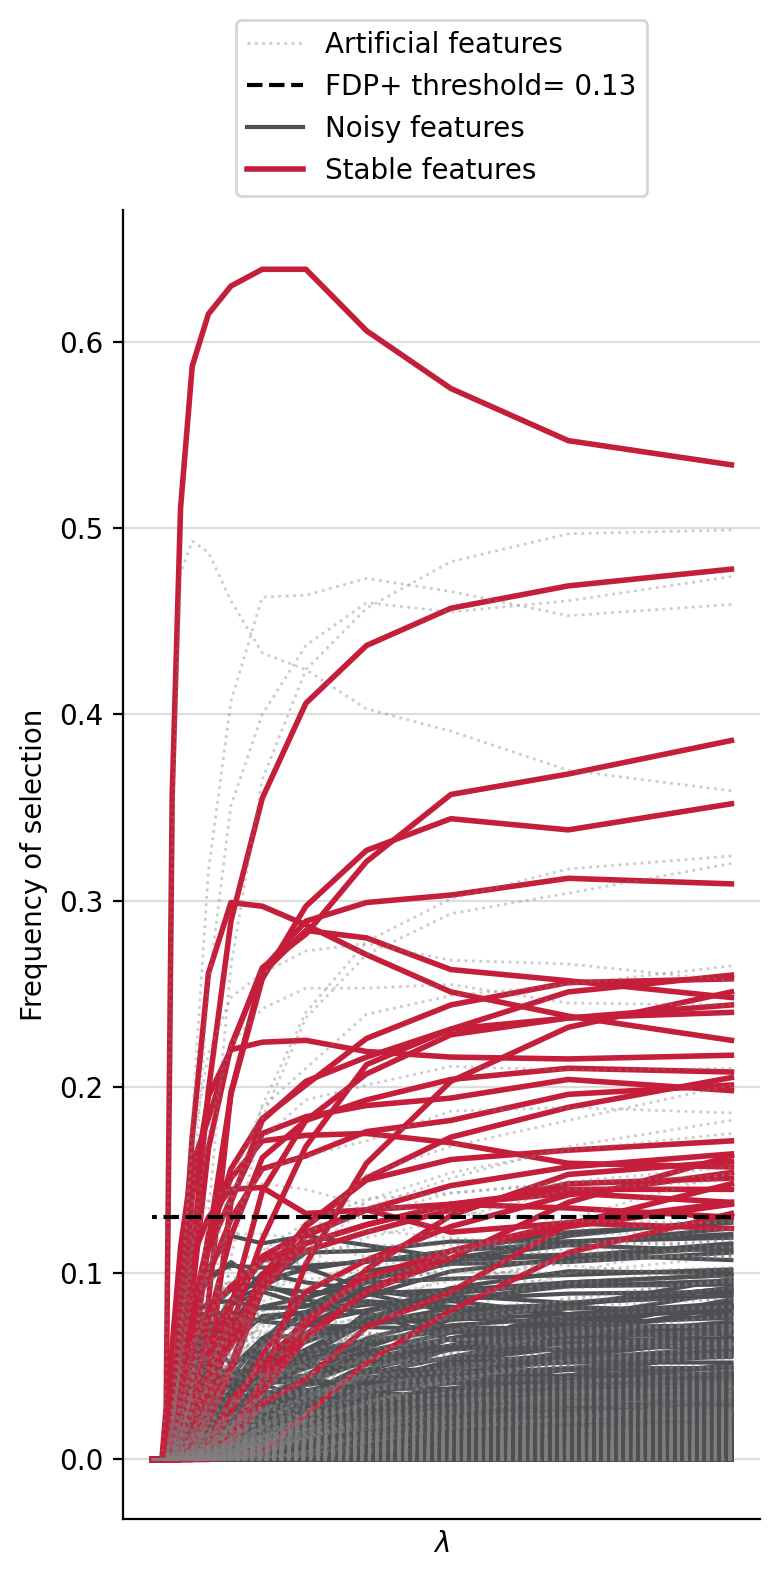

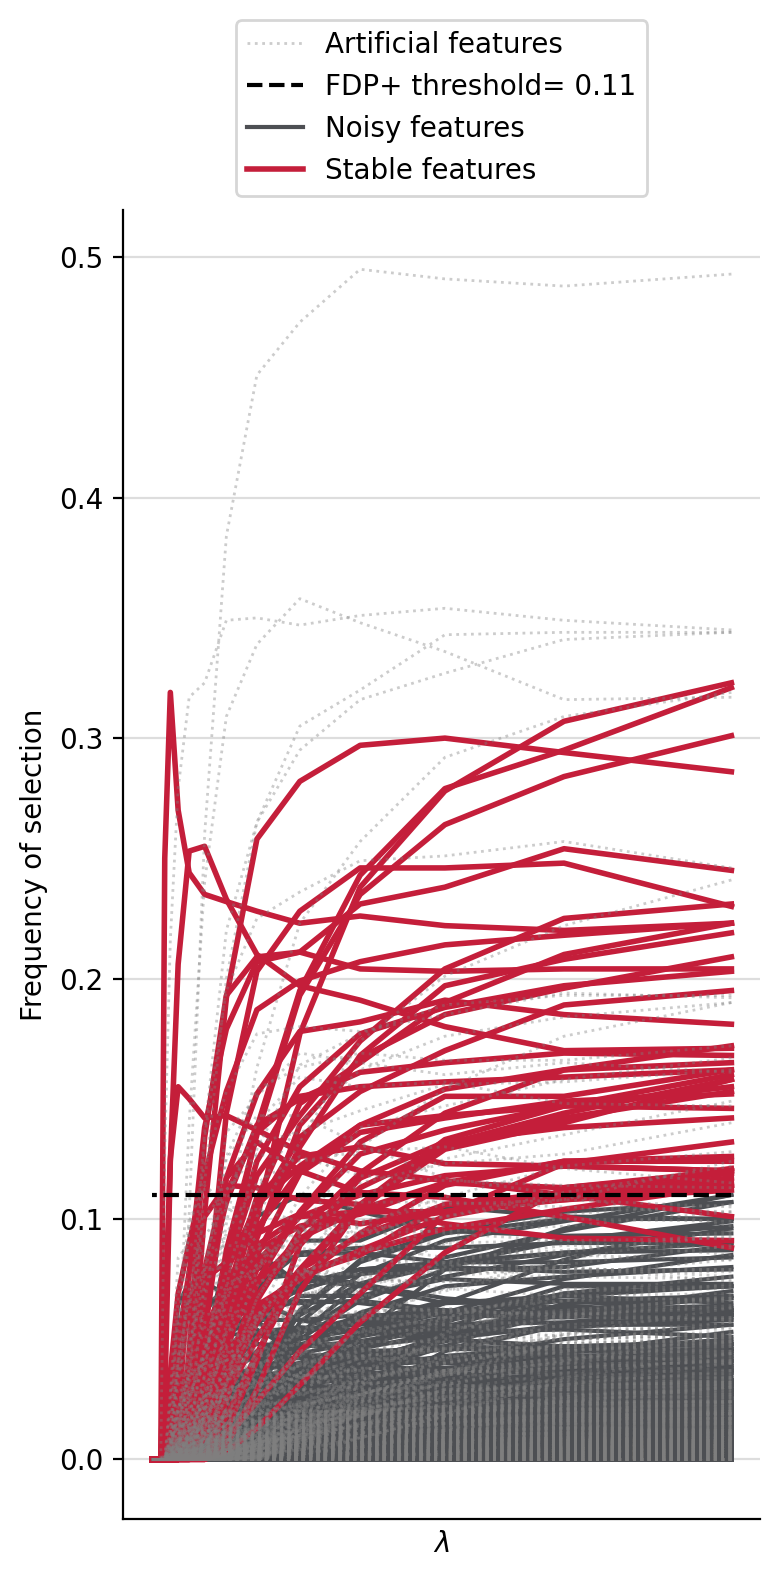

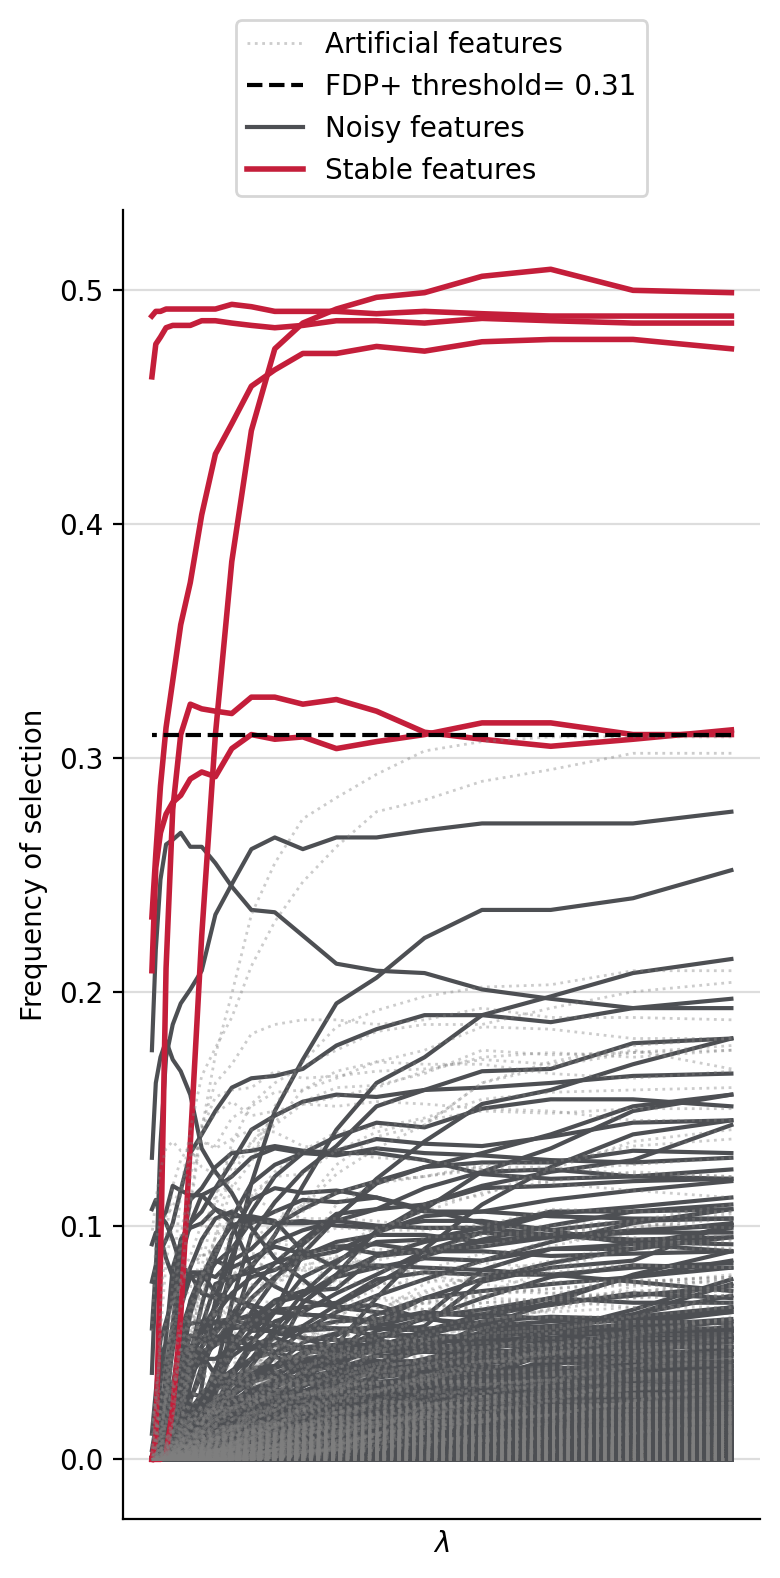

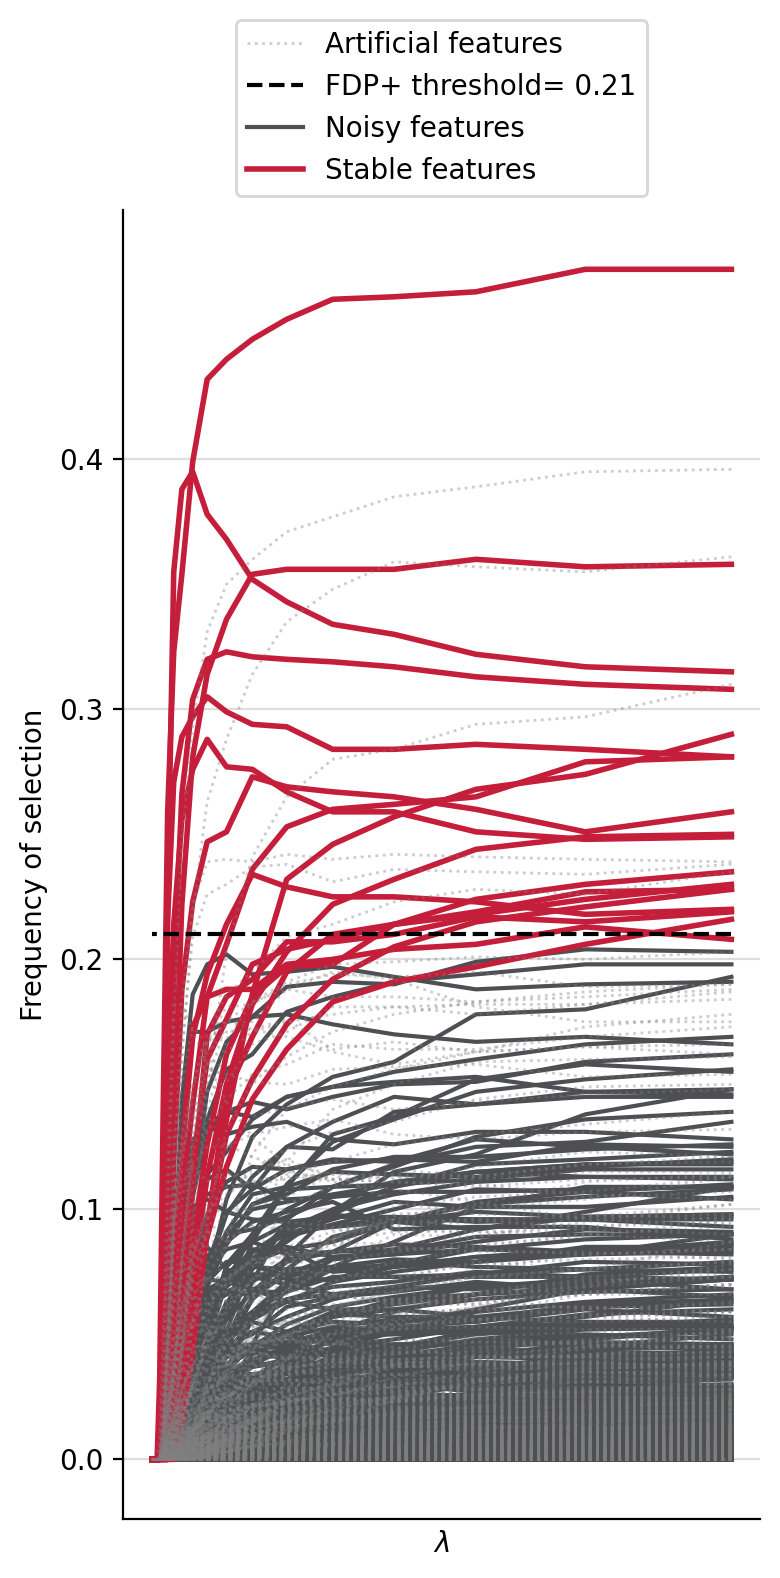

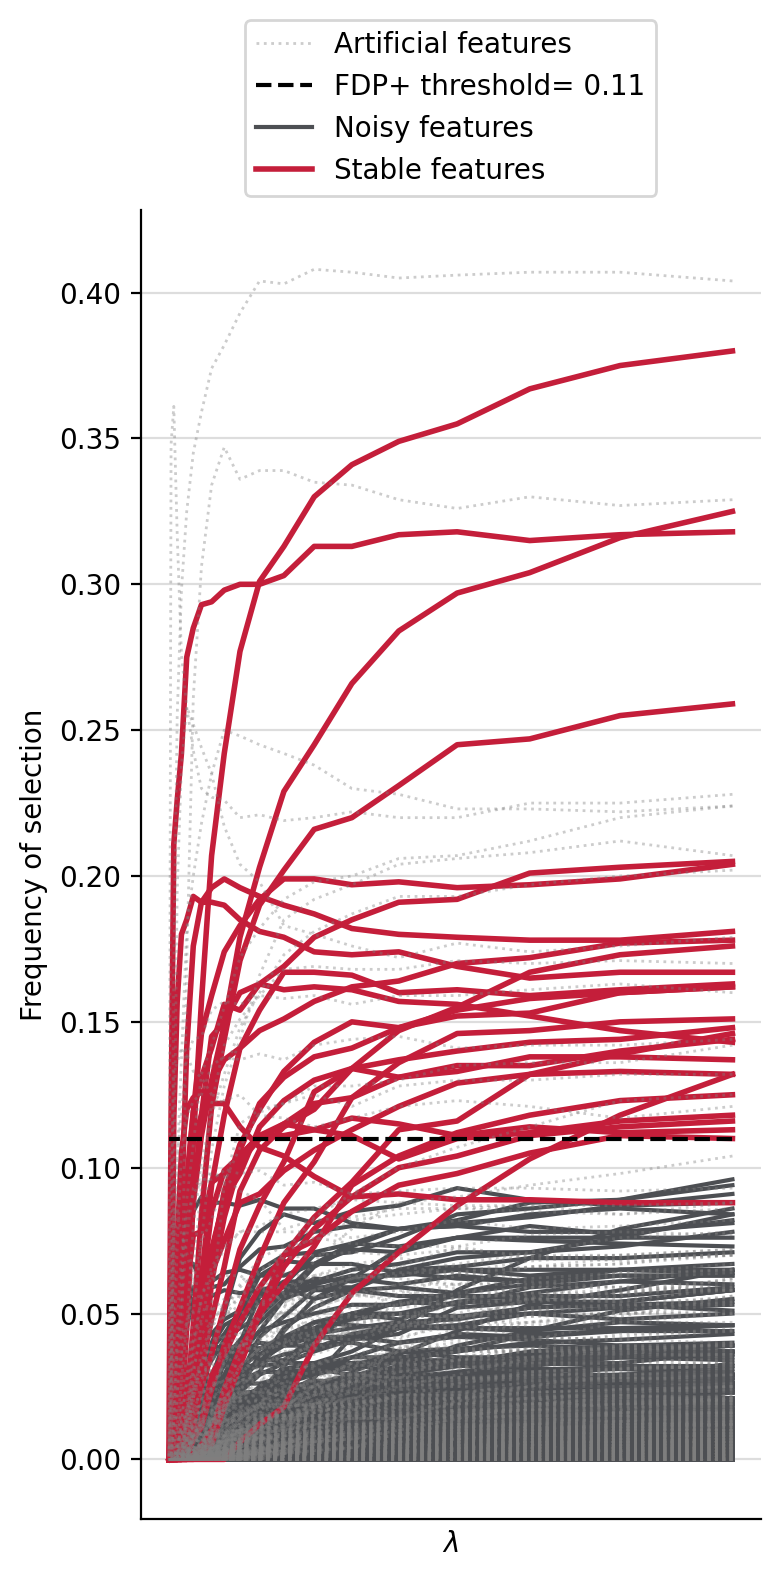

In [13]:
for challenge, stabl_regr in stabl_regression_dict.items():
    plot_fdr_graph(stabl_regr, figsize=(6, 4))

for challenge, stabl_regr in stabl_regression_dict.items():
    plot_stabl_path(stabl_regr, figsize=(4, 8))

In [ ]:
# Create dictionary of selected features for each challenge. 
selected_features_dict = {}
for challenge, stabl_regr in stabl_regression_dict.items():
    selected_features = stabl_regr.get_feature_names_out()
    print("Outcome:", challenge, "Num features:", len(selected_features))
    print(selected_features)
    selected_features_dict[challenge] = selected_features

# Creates a dictionary of relevant training data for each challenge.
relevant_training_data_dict = {}
for challenge, stabl_regr in stabl_regression_dict.items():
    selected_features = stabl_regr.get_support(indices=True)
    relevant_training_data_dict[challenge] = training_data_dict[challenge].iloc[:, selected_features]

Outcome: 1.1) IgG-PT-D14-titer-Rank Num features: 59
['IgG_PT' 'IgG1_PT' 'IgG1_PRN' 'IgG1_FHA' 'IgG1_FIM2/3' 'IgG1_DT'
 'IgG2_DT' 'IgG2_OVA' 'IgG3_PT' 'IgG3_DT' 'IgG4_OVA' 'P05231' 'P80098'
 'P01133' 'Q07325' 'O95760' 'Q99731' 'P10147' 'P09603' 'P01135' 'P01374'
 'P03956' 'P09919' 'P40933' 'P49771' 'Q16552' 'ENSG00000012223.12'
 'ENSG00000064886.13' 'ENSG00000076924.11' 'ENSG00000100376.11'
 'ENSG00000109113.19' 'ENSG00000117751.17' 'ENSG00000122877.15'
 'ENSG00000148346.11' 'ENSG00000158773.14' 'ENSG00000163993.6'
 'ENSG00000164047.4' 'ENSG00000166164.15' 'ENSG00000183813.6'
 'ENSG00000188536.12' 'ENSG00000189068.9' 'ENSG00000198502.5'
 'ENSG00000232629.8' 'ENSG00000233276.3' 'ENSG00000240403.5'
 'Non-Classical_Monocytes' 'CD4Tcells' 'NaiveCD4' 'TemCD4' 'TcmCD4'
 'TcmCD8' 'NK' 'Basophils' 'Proliferating B cells'
 'Activated B cells (ABCs)'
 'CD3-CD19-CD56-CD14-CD16-CD123-CD11c-HLA-DR+cells' 'cDC1' 'infancy_vac'
 'age']
Outcome: 1.2) IgG-PT-D14-FC-Rank Num features: 11
['IgG_PT' 'IgG1_

In [ ]:
def spearman_correlation(y_true, y_pred):
    # Calculate Spearman correlation
    if np.std(y_pred) == 0:
        return -1
    rho, _ = spearmanr(y_true, y_pred)
    return rho  # Higher is better


# Convert it into a scikit-learn scorer
spearman_scorer = make_scorer(spearman_correlation, greater_is_better=True)

# Create ElasticNet model and perform grid search for hyperparameter tuning.
best_model_accuracy_dict = {}
best_model_dict = {}
best_model_features_dict = {}
for challenge, stabl_regr in stabl_regression_dict.items():
    # Create a grid search for hyperparameter tuning of ElasticNet model.
    model = ElasticNet(max_iter=int(1e7), random_state=random_state)
    param_grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5], "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=spearman_scorer)

    grid_search.fit(relevant_training_data_dict[challenge], outcomes_dict[challenge])

    best_param = grid_search.best_params_
    best_score = grid_search.best_score_

    print(challenge, "Best Parameter (C):", best_param, "Cross-Validated Score:", best_score)

    best_model = ElasticNet(
        best_param["alpha"], l1_ratio=best_param["l1_ratio"], max_iter=int(1e6), random_state=random_state
    )

    # Perform cross-validation to inspect best model's performance.
    scores = cross_val_score(
        best_model, relevant_training_data_dict[challenge], outcomes_dict[challenge], scoring=spearman_scorer, cv=5
    )

    # Print scores for each fold and the mean score
    print("Cross-Validation Scores:", scores)
    print("Mean Cross-Validation Score:", scores.mean())

    model = ElasticNet(
        alpha=best_param["alpha"], l1_ratio=best_param["l1_ratio"], max_iter=int(1e7), random_state=random_state
    )
    model.fit(relevant_training_data_dict[challenge], outcomes_dict[challenge])
    accuracy = model.score(relevant_training_data_dict[challenge], outcomes_dict[challenge])
    print("MODEL ACCURACY:", accuracy)
    y_pred = model.predict(relevant_training_data_dict[challenge])
    spearmanc = spearman_correlation(outcomes_dict[challenge], y_pred)
    print("SPEARMAN CORRELATION: ", spearmanc)
    print(model.coef_)

    best_model_accuracy_dict[challenge] = spearmanc
    best_model_dict[challenge] = model
    assert len(model.feature_names_in_) == len(model.coef_)
    # Create a list of feature and their weights in the model for each challenge.
    features_weight_list = []
    for i in range(0, len(model.coef_)):
        features_weight_list.append((model.feature_names_in_[i], model.coef_[i]))
    assert len(features_weight_list) == len(model.coef_)
    sorted_features_weight_list = sorted(features_weight_list, key=lambda x: abs(x[1]), reverse=True)
    best_model_features_dict[challenge] = sorted_features_weight_list

# Print best model accuracy for each challenge.
for key, value in best_model_accuracy_dict.items():
    print(key, value)

# Save the results of the experiment.
with open(experiment + ".modelinfo", "w") as file:
    file.write(str(datasets_to_use) + "\n")
    file.write("Prune assay " + str(prune_assay) + "\n")
    for key, value in best_model_accuracy_dict.items():
        file.write(key + " " + str(value) + "\n")

for key, value in best_model_features_dict.items():
    with open(experiment + "-" + key[:3], "w") as file:
        for feature in value:
            file.write(feature[0] + " " + str(feature[1]) + "\n")

In [ ]:
# Use best model to make predictions on the challenge dataset.

# Load challenge dataset. 
challenge_dataset = ["2023_dataset"]
challenge_data = get_input_data(assay_data, batch_corrected_assays, challenge_dataset, timepoint=0).drop(
    "dataset", axis=1
)

# Get number of subjects and features in the challenge dataset.
print("Input subjects: ", len(challenge_data))
print("Input features: ", len(challenge_data.columns))
assert len(challenge_data.columns.unique()) == len(challenge_data.columns)

predictions_dict = {}
ranks_dict = {}

# Preprocess the challenge data.
challenge_data = preprocess_training_data(challenge_data, outcome="all", filter_threshold=1).sort_index()

# For each challenge, make predictions using the best model and calculate ranks.
for challenge, model in best_model_dict.items():
    predictions_dict[challenge] = pd.Series(
        model.predict(challenge_data.loc[:, selected_features_dict[challenge]]), index=challenge_data.index
    )
    ranks_dict[challenge] = predictions_dict[challenge].rank(method="first", ascending=False).astype(int)
    ranks_dict[challenge].name = challenge


# Create a final dataframe with all predictions and ranks for the challenge dataset.
final = pd.concat(ranks_dict.values(), axis=1)

# Merge with subjects to get subject information in final dataframe.
subjects = specimens[specimens["dataset"] == challenge_dataset[0]].drop("dataset", axis=1)
subjects = subjects[subjects["timepoint"] == 0].drop("timepoint", axis=1).set_index("subject_id")
final = subjects.merge(final, left_index=True, right_index=True, how="right").drop("date_of_boost", axis=1)
assert len(final) == 54
final.index.name = "SubjectID"
final = final.rename(
    columns={"infancy_vac": "VaccinePrimingStatus", "age": "Age", "biological_sex": "BiologicalSexAtBirth"}
)
ordered_columns = ["Age","BiologicalSexAtBirth","VaccinePrimingStatus"]
ordered_columns += challenges
final = final[ordered_columns]

# Save final rank results to a TSV file.
final.to_csv(experiment + ".tsv", sep="\t", index=True)

Input subjects:  54
Input features:  6778
